In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary

import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf

from tqdm import tqdm
import random
import numpy as np

import matplotlib.patches as mpatches
from typing import List, Optional, Tuple

import torch
import hydra
import pyrootutils
import pytorch_lightning as pl
from omegaconf import DictConfig
from pytorch_lightning import (Callback, LightningDataModule, LightningModule,
                               Trainer)
from pytorch_lightning.loggers import TensorBoardLogger

# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)

import src.utils.default as utils

log = utils.get_pylogger(__name__)

torch.set_float32_matmul_precision('medium')
# torch.autograd.set_detect_anomaly(True)

from src.models.simclr import SimCLR

from src.models.unet3d.model_encoders import UNet3D as UNet3D_Encoder


import SimpleITK as sitk
sitk.ProcessObject_SetGlobalWarningDisplay(False)



In [2]:
trainer = Trainer(gpus=None)

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/vladyslavz/anaconda3/envs/css/lib/python3.10 ...
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.


In [3]:
segm_cfg = OmegaConf.load('/mrhome/vladyslavz/git/central-sulcus-analysis/sulci_segm_logs/CS1x_tversky_BVISA_SST_monai_PRETRAINED_frozenENCODER_orientCOrrect/runs/2023-04-11_10-38-38/.hydra/config.yaml')

segm_datamodule: LightningDataModule = hydra.utils.instantiate(segm_cfg.data)

segm_model: LightningModule = hydra.utils.instantiate(segm_cfg.model)

print(segm_cfg.data)

2023-04-11 11:56:15,602 - Len of train examples 38 len of validation examples 12
Loading encoder weights from checkpoint...
/mrhome/vladyslavz/git/central-sulcus-analysis/sulci_segm_logs/sst-bvisa-1x-monai-BasicUnet/runs/2023-04-10_11-38-09/checkpoints/epoch-108_val_loss-0.078.ckpt
U-Net Embedding dimension: 458752


Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


Freezing encoder...


Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
Attribute 'loss_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_function'])`.


{'_target_': 'src.data.bvisa_augm_dm.CS_DataModule', 'dataset_cfg': {'dataset': 'bvisa', 'target': 'central_sulcus', 'dataset_path': '/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa_augm/nobackup/generated', 'use_half_brain': False, 'resample': None, 'crop2content': False, 'padd2same_size': '256-256-124'}, 'train_batch_size': 1, 'validation_batch_size': 1, 'num_workers': 1, 'double_validation': True}


In [4]:
simclr_cfg = OmegaConf.load('/mrhome/vladyslavz/git/central-sulcus-analysis/logs/sst-full-res-corrected-skullstripHALF1000Epochs-unet-allAugm2/runs/2023-03-31_14-39-48/.hydra/config.yaml')

simclr_datamodule: LightningDataModule = hydra.utils.instantiate(simclr_cfg.data)
simclr_model: LightningModule = hydra.utils.instantiate(simclr_cfg.model)
simclr_model = SimCLR.load_from_checkpoint('/mrhome/vladyslavz/git/central-sulcus-analysis/logs/sst-full-res-corrected-skullstripHALF1000Epochs-unet-allAugm2/runs/2023-03-31_14-39-48/checkpoints/epoch-472_val_loss-0.000.ckpt')

2023-04-05 13:20:10,771 - Len of train examples 16 len of validation examples 4
U-Net Embedding dimension: 32768


Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [5]:
simclr_model.mlp_head[0].encoders = segm_model.net.encoders

In [6]:
trainer.validate(simclr_model, datamodule=simclr_datamodule)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_top1        │            0.0            │
│       val_acc_top5        │           50.0            │
│         val_loss          │    1.1932947635650635     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.1932947635650635, 'val_acc_top1': 0.0, 'val_acc_top5': 50.0}]

In [12]:
trainer.validate(model, datamodule=datamodule)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_top1        │            0.0            │
│       val_acc_top5        │           50.0            │
│         val_loss          │    2.5284535884857178     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 2.5284535884857178, 'val_acc_top1': 0.0, 'val_acc_top5': 50.0}]

In [14]:
model = model.load_from_checkpoint('/mrhome/vladyslavz/git/central-sulcus-analysis/logs/sst-full-res-corrected-skullstripHALF1000Epochs-unet-allAugm2/runs/2023-03-31_14-39-48/checkpoints/epoch-472_val_loss-0.000.ckpt')


U-Net Embedding dimension: 32768


Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [15]:
trainer.validate(model, datamodule=datamodule)

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/vladyslavz/anaconda3/envs/css/lib/python3.10 ...


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_top1        │           100.0           │
│       val_acc_top5        │           100.0           │
│         val_loss          │   0.0027806537691503763   │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.0027806537691503763,
  'val_acc_top1': 100.0,
  'val_acc_top5': 100.0}]

In [7]:
segm_cfg = OmegaConf.load('/mrhome/vladyslavz/git/central-sulcus-analysis/sulci_segm_logs/112_augm_CS_1x_tversky_orient_corrected/runs/2023-04-04_14-49-16/.hydra/config.yaml')
segm_model: LightningModule = hydra.utils.instantiate(segm_cfg.model)


Loading encoder weights from checkpoint...
/mrhome/vladyslavz/git/central-sulcus-analysis/logs/sst-full-res-corrected-skullstripHALF1000Epochs-unet-allAugm2/runs/2023-03-31_14-39-48/checkpoints/epoch-472_val_loss-0.000.ckpt
U-Net Embedding dimension: 32768


In [8]:
cfg = OmegaConf.load('/mrhome/vladyslavz/git/central-sulcus-analysis/logs/sst-full-res-corrected-skullstripHALF1000Epochs-unet-allAugm2/runs/2023-03-31_14-39-48/.hydra/config.yaml')
model: LightningModule = hydra.utils.instantiate(cfg.model)

U-Net Embedding dimension: 32768


In [11]:
model.mlp_head[0].encoders = segm_model.net.encoders
trainer.validate(model, datamodule=datamodule)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_top1        │           87.5            │
│       val_acc_top5        │           100.0           │
│         val_loss          │    0.6743736863136292     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.6743736863136292, 'val_acc_top1': 87.5, 'val_acc_top5': 100.0}]

In [12]:
segm_cfg = OmegaConf.load('/mrhome/vladyslavz/git/central-sulcus-analysis/sulci_segm_logs/112_augm_CS_1x_tversky_orient_corrected/runs/2023-04-04_14-49-16/.hydra/config.yaml')
segm_cfg.model.encoder_chkp = None
segm_model: LightningModule = hydra.utils.instantiate(segm_cfg.model)


In [13]:
model.mlp_head[0].encoders = segm_model.net.encoders
trainer.validate(model, datamodule=datamodule)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_top1        │            0.0            │
│       val_acc_top5        │           50.0            │
│         val_loss          │    1.9209296703338623     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.9209296703338623, 'val_acc_top1': 0.0, 'val_acc_top5': 50.0}]

In [1]:
a ='/mrhome/vladyslavz/git/central-sulcus-analysis/sulci_segm_logs/sst-bvisa-1x/runs/2023-04-05_15-11-27/.hydra/config.yaml'

In [9]:
cfg = OmegaConf.load(a)

In [10]:
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.data)
model: LightningModule = hydra.utils.instantiate(cfg.model)

2023-04-05 15:17:58,175 - Len of train examples 38 len of validation examples 12
U-Net Embedding dimension: 32768


Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [28]:
for i in range(len(datamodule.val_dataset)):
    print(datamodule.train_dataset[i][0][0].shape)

AttributeError: 'ContrastiveDataModule' object has no attribute 'test_dataset'

In [23]:
b[0][0].shape

torch.Size([1, 124, 256, 256])

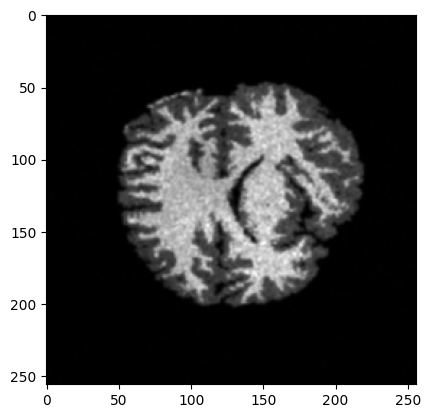

In [22]:
plt.imshow(b[0][0][0,80, :, :], cmap='gray')

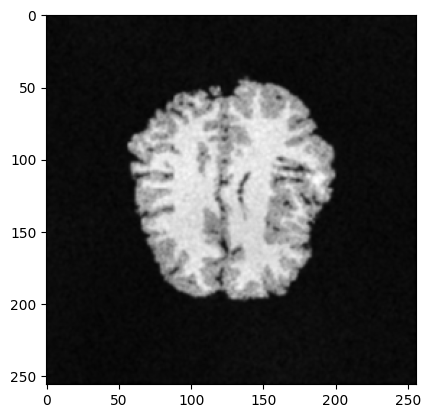

In [21]:
plt.imshow(b[0][1][0,80, :, :], cmap='gray')

In [1]:
from monai.networks.nets import UNETR, Unet, Basicunet, UNet

In [2]:
from src.models.monai_impl import  BasicUNetEncoder

ModuleNotFoundError: No module named 'src'

In [3]:
net=Basicunet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    features= (32, 32, 64, 128, 256, 32),
    upsample='deconv',
).to('cpu')

In [4]:
import torchsummary

In [9]:
[x for x in net.children()][5]

UpCat(
  (upsample): UpSample(
    (deconv): ConvTranspose3d(256, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  )
  (convs): TwoConv(
    (conv_0): Convolution(
      (conv): Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
)

In [6]:
torchsummary.summary(net, (1, 128, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 32, 128, 128, 128]             896
    InstanceNorm3d-2    [-1, 32, 128, 128, 128]              64
           Dropout-3    [-1, 32, 128, 128, 128]               0
         LeakyReLU-4    [-1, 32, 128, 128, 128]               0
            Conv3d-5    [-1, 32, 128, 128, 128]          27,680
    InstanceNorm3d-6    [-1, 32, 128, 128, 128]              64
           Dropout-7    [-1, 32, 128, 128, 128]               0
         LeakyReLU-8    [-1, 32, 128, 128, 128]               0
         MaxPool3d-9       [-1, 32, 64, 64, 64]               0
           Conv3d-10       [-1, 32, 64, 64, 64]          27,680
   InstanceNorm3d-11       [-1, 32, 64, 64, 64]              64
          Dropout-12       [-1, 32, 64, 64, 64]               0
        LeakyReLU-13       [-1, 32, 64, 64, 64]               0
           Conv3d-14       [-1, 32, 64,